In [15]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio
from PIL import Image, ImageOps
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
def get_histogram(images, scale):
    if scale == "rgb":
        colors = "rgb"
        pixel_vals = {"r":[], "g":[], "b":[]}
    else:
        colors = "k"
        pixel_vals = {"k":[]}
    for i in range(len(images)):
        for j in range(len(images[i][0])):
            for k in range(len(images[i][0][j])):
                for idx, color in enumerate(colors):
                    if color != "k":
                        pixel_vals[color].append(images[i][0][j][k][idx])
                    else:
                        pixel_vals[color].append(images[i][0][j][k])
    return pixel_vals

In [4]:
def plot_histograms(images, scale="rgb"):
    if scale == "rgb":
        colors = "rgb"
        num_plots = 3
    else:
        colors = "k"
        num_plots = 1
    pixel_vals = get_histogram(images, scale)
    fig, ax = plt.subplots(num_plots, figsize=(18,18))
    fig.suptitle("Histogram of Pixel Values")
    
    for i, color in enumerate(colors):
        if color != "k":
            ax[i].hist(pixel_vals[color], bins="auto")
            ax[i].set_xlabel("Pixel Value")
            ax[i].set_ylabel("Count")
            ax[i].set_title(f"{color} histogram")
        else:
            ax.set_xlabel("Pixel Value")
            ax.set_ylabel("Count")
            ax.set_title(f"{color} histogram")
            ax.hist(pixel_vals[color], bins="auto")

First let's read in the data and plot histograms for both RGB and Grey-scaled data to get a first look at the data.

In [6]:
images_0 = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/0/*.png"), ):
    img = np.array(Image.open(image_path))
    images_0.append((img, 0))
images_1 = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/1/*.png")):
    img = np.array(Image.open(image_path))
    images_1.append((img, 1))
images_rgb = images_0 + images_1

In [72]:
images_0 = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/0/*.png"), ):
    img = np.array(Image.open(image_path).convert("L"))
    images_0.append((img, 0))
images_1 = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/1/*.png")):
    img = np.array(Image.open(image_path).convert("L"))
    images_1.append((img, 1))
images_grey = images_0 + images_1

In [73]:
print(len(images_0))
print(len(images_1))

1531
1034


Note that the dataset is not quite balanced, we will address this later.

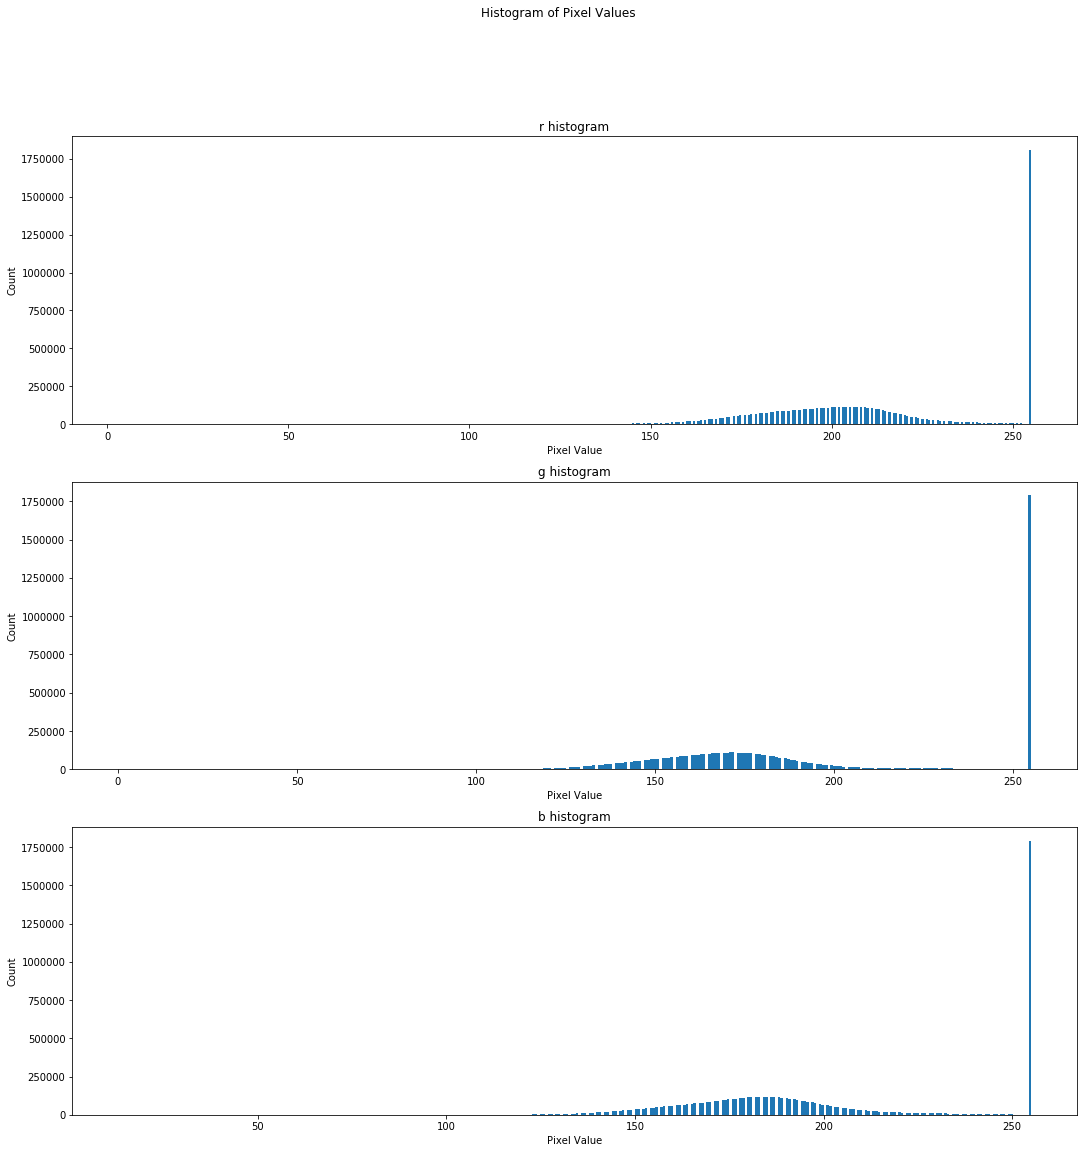

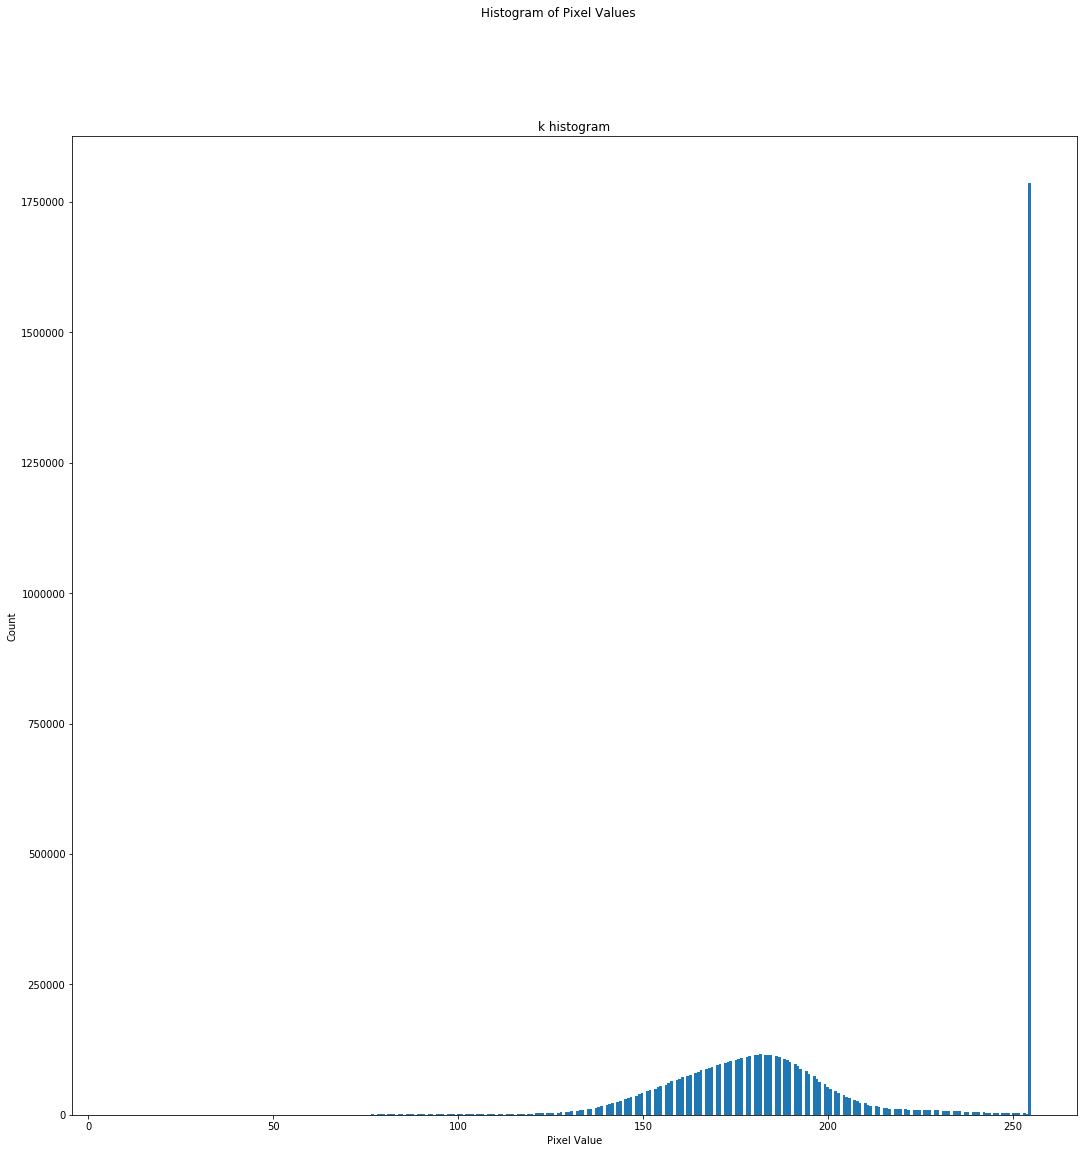

In [7]:
plot_histograms(images_rgb)
plot_histograms(images_grey, "grey")

It appears that the grey-scaling the image could be helpful, let's try and learn on each and see how we do. First, it is clear that most values are white (255). This would mean that most datapoints are not useful. A basis transformation could help with learning by aligning our components onto more meaningful vectors. So PCA would seem to be a smart option here. 

In [8]:
for i in range(10):
    print(images_grey[i][0].shape)

(55, 56)
(58, 55)
(53, 53)
(56, 54)
(52, 57)
(33, 32)
(63, 57)
(44, 55)
(35, 60)
(44, 53)


Here, we see each image is of a different size, where we need a consistent size for all of our images. Let's re-read the data so that we can resize each image to a consistent size. I will choose a square size of 64x64 for each image.

In [20]:
images_0 = []
images_0_rgb = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/0/*.png")):
    img = np.array(Image.open(image_path).convert("L").resize((64,64)))
    images_0.append((img, 0))
    img_rgb = np.array(Image.open(image_path).resize((64,64)))
    images_0_rgb.append((img_rgb, 0))
images_1 = []
images_1_rgb = []
for image_path in glob.glob(os.path.join(os.getcwd(), "uab curated/1/*.png")):
    img = np.array(Image.open(image_path).convert("L").resize((64,64)))
    images_1.append((img, 1))
    img_rgb = np.array(Image.open(image_path).resize((64,64)))
    images_1_rgb.append((img_rgb, 1))
images_grey_resized  = images_0 + images_1
images_rgb_resized  = images_0_rgb + images_1_rgb

In [10]:
for i in range(10):
    print(images_grey_resized[i][0].shape)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


Now, we have a consistent input shape into a learning process.

In [35]:
imgs_rgb = []
imgs_grey = []
classes = []
zeroes = []
ones = []
for index, img in enumerate(images_rgb_resized):
    imgs_rgb.append(img[0].flatten())
    imgs_grey.append(images_grey_resized[index][0].flatten())
    classes.append(img[1])
    if img[1] == 0:
        zeroes.append(index)
    else:
        ones.append(index)
imgs_rgb = np.array(imgs_rgb)
imgs_grey = np.array(imgs_grey)
classes = np.array(classes)

Now, we need to perform PCA. It is important to note here that we do not need to scale the data since it is already on a consistent, predefined scale ([0-255]) and so we can leave the data as is.

In [120]:
pca_rgb = PCA()
pca_rgb.fit(imgs_rgb)
print(len(pca_rgb.explained_variance_ratio_))

2565


There are 2565 components, but many of them may just be noise. Let's take only those components who contribute to at least 0.1% of the variance in the data. Which should shrink our dataset down significantly to reduce computation time.

In [39]:
pca_grey = PCA()
pca_grey.fit(imgs_grey)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [40]:
variance_break = 0.1
for i, evr in enumerate(pca_rgb.explained_variance_ratio_):
    if evr * 100 < variance_break:
        var_index_break_rgb = i
        print(i)
        break

85


In [41]:
variance_break = 0.1
for i, evr in enumerate(pca_grey.explained_variance_ratio_):
    if evr * 100 < variance_break:
        var_index_break_grey = i
        print(i)
        break

86


With pca, we are able to decrease the number of dimensions from 2565 down to only 85.

In [126]:
pca_rgb = PCA(n_components=var_index_break_rgb)
pca_rgb.fit(imgs_rgb)
imgs_rgb_pca = pca_rgb.transform(imgs_rgb)

In [43]:
pca_grey = PCA(n_components=var_index_break_grey)
pca_grey.fit(imgs_grey)
imgs_grey_pca = pca_grey.transform(imgs_grey)

Now, let's split the data into train, val, test data sets for learning. It is important to retain the same distribution of classes in the train, val and test datasets so we will sample from each class separately and then combine into one full dataset.

In [131]:
def train_val_test_split(train, val, test, zeroes, ones, seed=42):
    np.random.seed(seed)
    shuf_zeroes = np.random.shuffle(zeroes)
    shuf_ones = np.random.shuffle(ones)
    
    train_zeroes_stop = int(train*len(zeroes))
    val_zeroes_stop = int(val*len(zeroes)) + train_zeroes_stop
    
    train_ones_stop = int(train*len(ones))
    val_ones_stop = int(val*len(ones)) + train_ones_stop
    
    train_zeroes = zeroes[:train_zeroes_stop]
    if val != 0:
        val_zeroes = zeroes[train_zeroes_stop:val_zeroes_stop]
        test_zeroes = zeroes[val_zeroes_stop:]
    else:
        val_zeroes = []
        test_zeroes = zeroes[val_zeroes_stop:]
        
    train_ones = ones[:train_ones_stop]
    if val != 0:
        val_ones = ones[train_ones_stop:val_ones_stop]
        test_ones = ones[val_ones_stop:]
    else:
        val_ones = []
        test_ones = ones[val_ones_stop:]
        
    train_indices = train_zeroes + train_ones
    val_indices = val_zeroes + val_ones
    test_indices = test_zeroes + test_ones
        
    return train_indices, val_indices, test_indices

In [54]:
train_idx, val_idx, test_idx = train_val_test_split(0.5, 0.25, 0.25, zeroes, ones)

In [127]:
data = {}
for color in ["rgb", "grey"]:
    if color == "rgb":
        imgs_pca = imgs_rgb_pca
    else:
        imgs_pca = imgs_grey_pca
        
    train_data = imgs_pca[train_idx]
    val_data = imgs_pca[val_idx]
    test_data = imgs_pca[test_idx]

    data[color] = train_data, val_data, test_data
    
train_class = classes[train_idx]
val_class = classes[val_idx]
test_class = classes[test_idx]

Now, lets use a simple svm to see an unoptimized classifier on grey and rgb data.

In [128]:
svm_rgb = SVC(kernel="rbf", gamma='scale')
svm_rgb.fit(data["rgb"][0], train_class)
print(svm_rgb.score(data["rgb"][0], train_class))
print(svm_rgb.score(data["rgb"][2], test_class))

0.9773790951638065
0.895800933125972


In [70]:
svm_grey = SVC(kernel="rbf", gamma='scale')
svm_grey.fit(data["grey"][0], train_class)
print(svm_grey.score(data["grey"][0], train_class))
print(svm_grey.score(data["grey"][2], test_class))

0.8705148205928237
0.7465007776049767


It appears the grey-scaling was not effective. We will stick with the rgb data from here on out. Now, let's see how a random forest classifier performs on the dataset.

In [67]:
rf_val_scores = []
rf_train_scores = []
for max_depth in range(1, 15):
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=0)
    rf.fit(data["rgb"][0], train_class)
    rf_train_scores.append(1-rf.score(data["rgb"][0], train_class))
    rf_val_scores.append(1-rf.score(data["rgb"][1], val_class))

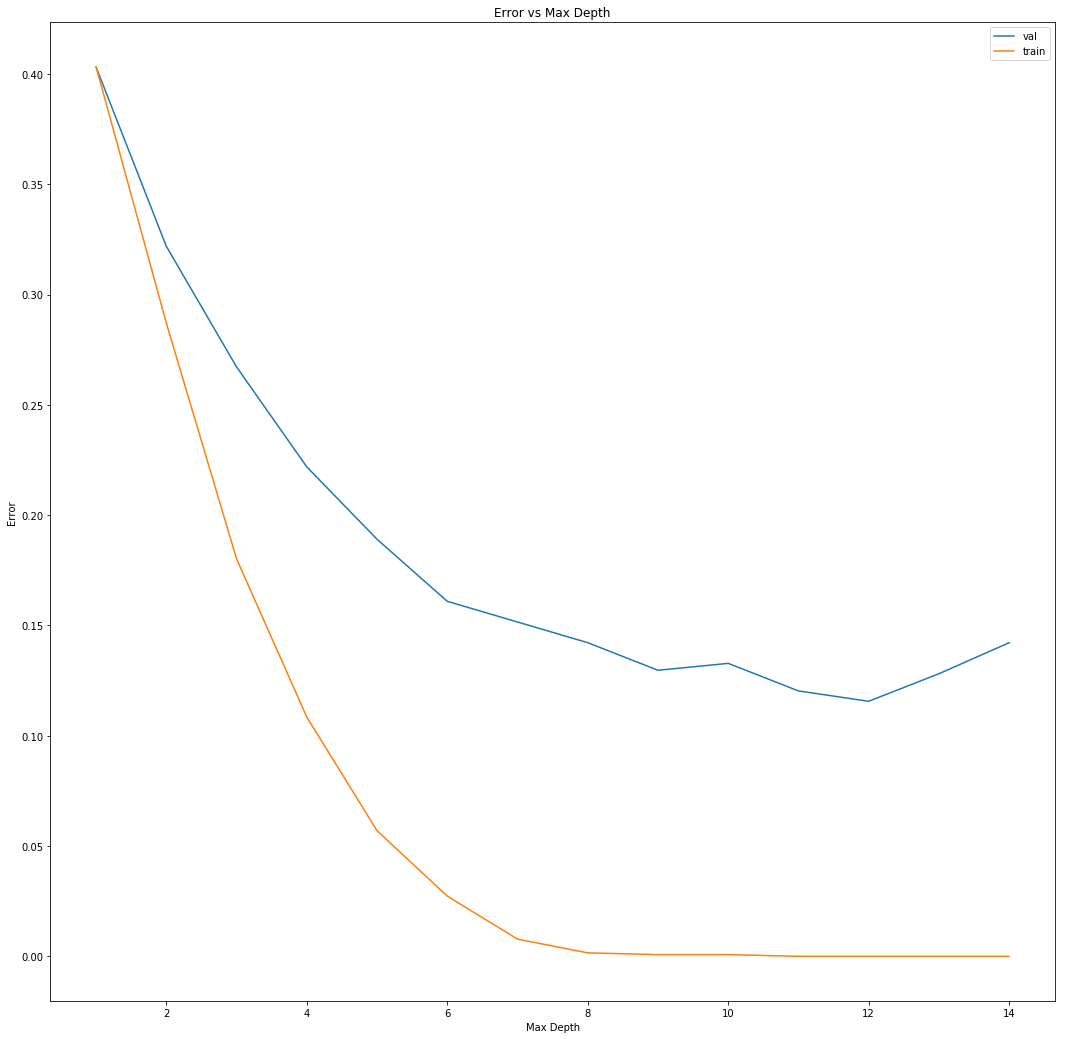

In [71]:
_ = plt.figure(figsize=(18,18))
_ = plt.title("Error vs Max Depth")
_ = plt.xlabel("Max Depth")
_ = plt.ylabel("Error")
_ = plt.plot([*range(1, 15)], rf_val_scores, label="val")
_ = plt.plot([*range(1, 15)], rf_train_scores, label="train")
_ = plt.legend()

It looks like a max depth of around 6 is optimal as we start to see some overfitting take effect as we increase our omplexity. However, even then the best we are really seeing performance wise is only about 85%. Which is less then our simpler and faster svm model. But let's check this with our fmeasure score for a better test of its score on an unbalanced dataset.

In [78]:
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
rf.fit(data["rgb"][0], train_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

We should stick with the svm, but let's check the confusion matrix to see how the classifier is doing with the dataset since it is not quite balanced.

In [74]:
def conf_mat(actual, predict):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(actual)):
        if actual[i] == predict[i] and actual[i]:
            tp += 1
        elif actual[i] == predict[i]:
            tn += 1
        elif predict[i]:
            fp += 1
        else:
            fn += 1
    return np.array([[tp, fn], [fp, tn]], dtype=int)

In [124]:
print(conf_mat(test_class, svm_rgb.predict(data["rgb"][2])))

[[197  62]
 [  8 376]]


The confusion matrix shows that we are getting a lot of false negatives. The data is not balanced so a pure classification accuracy is misleading and we should start using an f-score instead.

In [76]:
def fscore(conf_mat):
    tp, tn, fp, fn = conf_mat[0, 0], conf_mat[1, 1], conf_mat[1, 0], conf_mat[0, 1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fmeasure = 2 * recall * precision / (recall + precision)
    return fmeasure

In [80]:
print(fscore(conf_mat(test_class, svm_rgb.predict(data["rgb"][2]))))
print(fscore(conf_mat(test_class, rf.predict(data["rgb"][2]))))

0.8583690987124463
0.7344110854503465


So the svm does better with fmeasure as well, so we will in fact stick with the svm. Now to improve the fscore, we need to start predicting more positives. We can do this by giving a weight to the errors for each respective class when learning. The sklearn svm learner allows us to do this with the keyword arg class_weight. With the weights both equal to one we should get the same results as before.

In [129]:
svm_rgb = SVC(kernel="rbf", gamma='scale', class_weight={1: 1, 0: 1})
svm_rgb.fit(data["rgb"][0], train_class)
print(svm_rgb.score(data["rgb"][0], train_class))
print(svm_rgb.score(data["rgb"][2], test_class))
print(conf_mat(test_class, svm_rgb.predict(data["rgb"][2])))
print(fscore(conf_mat(test_class, svm_rgb.predict(data["rgb"][2]))))

0.9773790951638065
0.895800933125972
[[200  59]
 [  8 376]]
0.8565310492505354


Good. Now after trying several weights, we use a weighting of 1.24 for class 1 and 0.838 for class 0 to achieve the best performance. These numbers are weighted to the inverse of their frequency in the dataset.  
  
weight(class) = num_samples / (num_classes * count(class))

In [130]:
svm_rgb = SVC(kernel="rbf", gamma='scale', class_weight={1: 1.24, 0: 0.84})
svm_rgb.fit(data["rgb"][0], train_class)
print(svm_rgb.score(data["rgb"][0], train_class))
print(svm_rgb.score(data["rgb"][2], test_class))
print(conf_mat(test_class, svm_rgb.predict(data["rgb"][2])))
print(fscore(conf_mat(test_class, svm_rgb.predict(data["rgb"][2]))))

0.9859594383775351
0.9097978227060654
[[210  49]
 [  9 375]]
0.8786610878661087


Now, to improve the performance a little more, we can train on more of the data. So we need to resplit the data and see our final result. We should do this on several random samples of the data and get the average to see our performance.

In [139]:
fscores = []
for i in range(10):
    train_idx, _, test_idx = train_val_test_split(0.75, 0, 0.25, zeroes, ones, seed=i)
    train_data = imgs_rgb_pca[train_idx]
    test_data = imgs_rgb_pca[test_idx]
    train_class = classes[train_idx]
    test_class = classes[test_idx]
    svm_rgb = SVC(kernel="rbf", gamma='scale', class_weight={1: 1.24, 0: 0.84})
    svm_rgb.fit(train_data, train_class)
    fscores.append(fscore(conf_mat(test_class, svm_rgb.predict(test_data))))

Which results in a final performance for our model of :

In [144]:
mean = np.mean(fscores)
std = np.std(fscores)
print(f"Mean F-Measure Performance : {100*mean:.02f}%")
print(f"Std  F-Measure Performance :  {100*std:.02f}%")

Mean F-Measure Performance : 92.04%
Std  F-Measure Performance :  1.05%


In the end, a svm classifier with a balanced class weighting to help nudge classification a little more toward positives after a PCA using the first 85 components (0.1% variance components) of our rgb dataset resulted in the best performance for an average classification f-measure of 92% with a standard deviation of 1%.

Note, I also tried some boosting and bagging but there was no improvement in performance and they were much slower for classification.